In [1]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/Task3 Freight/CodeBase/skims')
plt.style.use('ggplot')

In [2]:
dist_dir = 'distance/'
highway_distance_skim = read_csv(dist_dir + 'FAF_od_highway_distance.csv', sep = ',')
rail_distance_skim = read_csv(dist_dir + 'FAF_od_rail_imx_distance.csv', sep = ',')
air_parcel_distance_skim = read_csv(dist_dir + 'FAF_od_gc_distance.csv', sep = ',')

In [3]:
highway_distance_skim.replace([np.inf, -np.inf], np.nan, inplace=True)
rail_distance_skim.replace([np.inf, -np.inf], np.nan, inplace=True)

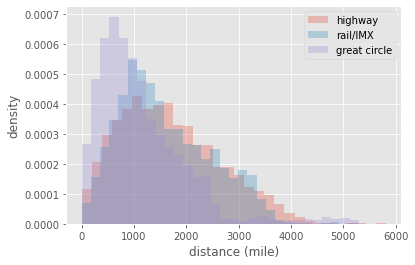

In [4]:
highway_distance_skim['routed_distance'].hist(bins = 30, alpha = 0.3, density=True)
rail_distance_skim['total_distance'].hist(bins = 30, alpha = 0.3, density=True)
air_parcel_distance_skim['gc_distance'].hist(bins = 30, alpha = 0.3,density=True)
plt.legend(['highway', 'rail/IMX', 'great circle'],loc= 1)
plt.xlabel('distance (mile)')
plt.ylabel('density')
plt.savefig('distance_distribution.png', dpi = 200)

In [5]:
def highway_travel_time(data, distance_var, distance_bin_var, cut_off = 150):
    data.loc[:, 'external'] = 1 * (data.loc[:, distance_bin_var] > cut_off) + \
                            0 * (data.loc[:, distance_bin_var] <= cut_off)
    # delivery less than 150 air-mile is designated as short-haul trip and does not apply FMCSA hour of service rules
    data.loc[:, 'speed'] = 20 * (data.loc[:, 'external'] == 0) + \
    (data.loc[:, 'external'] == 1) * (65 * (data.loc[:, distance_var] <= 650) + \
          38 * (data.loc[:, distance_var] > 650) * (data.loc[:, distance_var] <= 1300) + \
          32 * (data.loc[:, distance_var] > 1300))                                                     
    data.loc[:, 'travel_time'] = (data.loc[:, 'external'] == 0) * ( 4 + data.loc[:, distance_var] / data.loc[:, 'speed']) + \
    (data.loc[:, 'external'] == 1) * ( 16 + data.loc[:, distance_var] / data.loc[:, 'speed'])
    return(data)

In [6]:
# estimate travel time
highway_distance_skim_with_gc = pd.merge(highway_distance_skim, air_parcel_distance_skim, 
                                 on = ['origin_FAF', 'dest_FAF'], how = 'left')
highway_distance_skim_with_gc = highway_travel_time(highway_distance_skim_with_gc, 'routed_distance', 'gc_distance')
highway_distance_skim_with_gc.head(5)

,origin_FAF,dest_FAF,routed_distance,gc_distance,external,speed,travel_time
0,11,11,0.00,0.000000,0,20,4.000000
1,11,12,282.27,207.000164,1,65,20.342615
2,11,19,128.38,47.245661,0,20,10.419000
3,11,41,1811.38,1460.759750,1,32,72.605625
4,11,42,1694.60,1451.066440,1,32,68.956250


<AxesSubplot:>

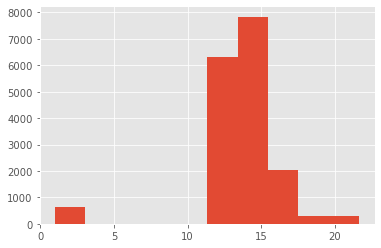

In [7]:
air_parcel_distance_skim.loc[:, 'speed'] = 549.5
air_parcel_distance_skim.loc[:, 'external'] = 1 * (air_parcel_distance_skim.loc[:, 'gc_distance'] > 150) + \
                            0 * (air_parcel_distance_skim.loc[:, 'gc_distance'] <= 150)
air_parcel_distance_skim.loc[:, 'wait_time'] = 1 * (air_parcel_distance_skim.loc[:, 'external'] == 0) + \
12* (air_parcel_distance_skim.loc[:, 'external'] == 1)
air_parcel_distance_skim.loc[:, 'travel_time'] = air_parcel_distance_skim.loc[:, 'wait_time'] + air_parcel_distance_skim.loc[:, 'gc_distance']/ air_parcel_distance_skim.loc[:, 'speed']
air_parcel_distance_skim.head(5)
air_parcel_distance_skim.loc[:, 'travel_time'].hist()

In [9]:
alternatives = [1*24, 3*24, 5*24]
probability = [0.18, 0.09, 0.73]
def generate_parcel_travel_time(alternatives, probability, n = 1):
    travel_time = np.random.choice(alternatives, size = n, p = probability)
    return(travel_time[0])
    
parcel_travel_time = air_parcel_distance_skim.loc[:, ['origin_FAF', 'dest_FAF', 'gc_distance']]
parcel_travel_time.loc[:, 'travel_time'] = parcel_travel_time.apply(lambda row: generate_parcel_travel_time(alternatives, probability),axis=1)
parcel_travel_time.head(5)

,origin_FAF,dest_FAF,gc_distance,travel_time
0,11,11,0.000000,120
1,11,12,207.000164,24
2,11,19,47.245661,120
3,11,20,3445.902887,120
4,11,41,1460.759750,120


In [10]:
rail_distance_skim_out = rail_distance_skim.copy()
rail_distance_skim_out.loc[:, 'rail_travel_time'] = rail_distance_skim_out['rail_distance']/22 + 12*2
rail_distance_skim_out = highway_travel_time(rail_distance_skim_out, 'arrive_terminal_dist', 'arrive_terminal_dist')
rail_distance_skim_out.rename(columns = {'external': 'arrival_external', 
                                     'speed': 'arrival_speed', 
                                     'travel_time':'arrival_travel_time'}, inplace = True)

rail_distance_skim_out = highway_travel_time(rail_distance_skim_out, 'depart_terminal_dist', 'depart_terminal_dist')
rail_distance_skim_out.rename(columns = {'external': 'depart_external', 
                                     'speed': 'depart_speed', 
                                     'travel_time':'depart_travel_time'}, inplace = True)
rail_distance_skim_out.loc[:, 'total_travel_time'] = rail_distance_skim_out.loc[:, ['rail_travel_time', 'arrival_travel_time', 'depart_travel_time']].sum(axis=1, skipna=False)

rail_distance_skim_out.head(5)

,origin_FAF,dest_FAF,origin_terminal,dest_terminal,rail_distance,arrive_terminal_dist,depart_terminal_dist,drive_distance,total_distance,rail_travel_time,arrival_external,arrival_speed,arrival_travel_time,depart_external,depart_speed,depart_travel_time,total_travel_time
0,279,11,61,11,1118.150222,166.18,24.17,190.35,1308.500222,74.825010,1,65,18.556615,0,20,5.2085,98.590125
1,488,11,147,11,873.230199,14.33,24.17,38.50,911.730199,63.692282,0,20,4.716500,0,20,5.2085,73.617282
2,280,11,83,11,234.912546,47.29,24.17,71.46,306.372546,34.677843,0,20,6.364500,0,20,5.2085,46.250843
3,484,11,50,11,635.635713,23.38,24.17,47.55,683.185713,52.892532,0,20,5.169000,0,20,5.2085,63.270032
4,172,11,62,11,503.522024,34.03,24.17,58.20,561.722024,46.887365,0,20,5.701500,0,20,5.2085,57.797365


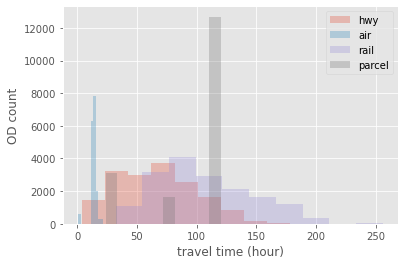

In [11]:
highway_distance_skim_with_gc['travel_time'].hist(alpha = 0.3)
air_parcel_distance_skim['travel_time'].hist(alpha = 0.3)
rail_distance_skim_out.loc[:, 'total_travel_time'].hist(alpha = 0.3)
parcel_travel_time.loc[:, 'travel_time'].hist(alpha = 0.3)
plt.legend(['hwy', 'air', 'rail', 'parcel'])
plt.xlabel('travel time (hour)')
plt.ylabel('OD count')
plt.savefig('trave_time_distribution.png', dpi = 300)


In [12]:
# write output
output_directory = 'travel_time/'
highway_skim_output = highway_distance_skim_with_gc.loc[:, ['origin_FAF', 'dest_FAF', 'routed_distance', 'travel_time']]
highway_skim_output.columns = ['origin_FAF', 'dest_FAF', 'distance', 'travel_time']
highway_skim_output.to_csv(output_directory + 'truck_travel_time_skim.csv')
print(len(highway_skim_output))

air_skim_output = air_parcel_distance_skim.loc[:, ['origin_FAF', 'dest_FAF', 'gc_distance', 'travel_time']]
air_skim_output.columns = ['origin_FAF', 'dest_FAF', 'distance', 'travel_time']
air_skim_output.to_csv(output_directory + 'air_travel_time_skim.csv')
print(len(air_skim_output))

parcel_skim_output = parcel_travel_time.loc[:, ['origin_FAF', 'dest_FAF', 'gc_distance', 'travel_time']]
parcel_skim_output.columns = ['origin_FAF', 'dest_FAF', 'distance', 'travel_time']
parcel_skim_output.to_csv(output_directory + 'parcel_travel_time_skim.csv')
print(len(parcel_skim_output))

rail_skim_output = rail_distance_skim_out.loc[:, ['origin_FAF', 'dest_FAF', 'total_distance', 'total_travel_time']]
rail_skim_output.columns = ['origin_FAF', 'dest_FAF', 'distance', 'travel_time']
rail_skim_output.to_csv(output_directory + 'rail_travel_time_skim.csv')
print(len(rail_skim_output))

17424
17424
17424
17424


In [13]:
cfs_faf_lookup = read_csv('CFS_FAF_LOOKUP.csv', sep = ',')
cfs_faf_lookup.head(5)

,STPOSTAL,STFIPS,CFSMA,ST_MA,FAF,CFSAREANAM,SHORTNAME
0,AL,1,142,01-142,11,"Birmingham-Hoover-Talladega, AL CFS Area",Birmingham
1,AL,1,380,01-380,12,"Mobile-Daphne-Fairhope, AL CFS Area",Mobile
2,AL,1,99999,01-99999,19,Remainder of Alabama,Rest of AL
3,AK,2,99999,02-99999,20,Alaska,Alaska
4,AZ,4,38060,04-38060,41,"Phoenix-Mesa-Glendale, AZ CFS Area",Phoenix


In [14]:
private_truck_skim = highway_skim_output.copy()
private_truck_skim.loc[:, 'mode'] = 'Private Truck'
for_hire_truck_skim = highway_skim_output.copy()
for_hire_truck_skim.loc[:, 'mode'] = 'For-hire Truck'
air_skim_output.loc[:, 'mode'] = 'Air'
parcel_skim_output.loc[:, 'mode'] = 'Parcel'
rail_skim_output.loc[:, 'mode'] = 'Rail/IMX'
combined_skim_output = pd.concat([private_truck_skim, for_hire_truck_skim, air_skim_output,
                             parcel_skim_output, rail_skim_output])
combined_skim_output.head(5)

,origin_FAF,dest_FAF,distance,travel_time,mode
0,11,11,0.00,4.000000,Private Truck
1,11,12,282.27,20.342615,Private Truck
2,11,19,128.38,10.419000,Private Truck
3,11,41,1811.38,72.605625,Private Truck
4,11,42,1694.60,68.956250,Private Truck


In [15]:
combined_skim_output_with_cfs = pd.merge(combined_skim_output, cfs_faf_lookup,
                                        left_on = 'origin_FAF', right_on = 'FAF', how = 'left')
combined_skim_output_with_cfs = combined_skim_output_with_cfs.rename(columns = {'ST_MA': 'ORIG_CFS_AREA'})
combined_skim_output_with_cfs = combined_skim_output_with_cfs.loc[:, ['origin_FAF', 'dest_FAF', 'distance', 'travel_time', 'mode', 'ORIG_CFS_AREA']]

combined_skim_output_with_cfs = pd.merge(combined_skim_output_with_cfs, cfs_faf_lookup,
                                        left_on = 'dest_FAF', right_on = 'FAF', how = 'left')
combined_skim_output_with_cfs = combined_skim_output_with_cfs.rename(columns = {'ST_MA': 'DEST_CFS_AREA'})
combined_skim_output_with_cfs = combined_skim_output_with_cfs.loc[:, ['origin_FAF', 'dest_FAF', 'distance', 'travel_time', 'mode', 'ORIG_CFS_AREA', 'DEST_CFS_AREA']]
combined_skim_output_with_cfs.head(5)

,origin_FAF,dest_FAF,distance,travel_time,mode,ORIG_CFS_AREA,DEST_CFS_AREA
0,11,11,0.00,4.000000,Private Truck,01-142,01-142
1,11,12,282.27,20.342615,Private Truck,01-142,01-380
2,11,19,128.38,10.419000,Private Truck,01-142,01-99999
3,11,41,1811.38,72.605625,Private Truck,01-142,04-38060
4,11,42,1694.60,68.956250,Private Truck,01-142,04-536


In [18]:
combined_skim_output.columns = ['orig_FAFID', 'dest_FAFID', 'Distance', 'Travel_time', 'Alternative']
combined_skim_output.to_csv(output_directory + 'combined_travel_time_skim.csv', index = False)
combined_skim_output_with_cfs.to_csv(output_directory + 'combined_travel_time_skim_with_cfs.csv', index = False)